# Transformer Experiments

## Packages and Presets

In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
from icecream import ic


import matplotlib.pyplot as plt
import seaborn as sns   

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split



from transformer_utils import PTB_Dataset, test

from transformer import Transformer

pd.set_option('display.max_columns', None)
%load_ext blackcellmagic
%load_ext autoreload

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with open("transformer_config.yaml", "r") as file:
    config = yaml.safe_load(file)
    
np.random.seed(config["general"]["seed"])

## Performance Evaluation

In [3]:
# Load data
train_df = pd.read_csv(config["paths"]["ptb_train"], header=None)
test_df = pd.read_csv(config["paths"]["ptb_test"], header=None)

In [4]:
X_train_full = train_df.iloc[:, :-1].to_numpy()
y_train_full = train_df.iloc[:, -1].to_numpy()

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

Contrary to the `train_transformer.py` script, we will here not make use of SMOTE oversampling as this notebook is only about evaluating the model performance on the test set and visualizing the attention map of some representative images.

In [6]:
train_loader = DataLoader(
    PTB_Dataset(X_train, y_train), batch_size=config["dataloader"]["train_batch_size"], shuffle=True, pin_memory=True
)
val_loader = DataLoader(
    PTB_Dataset(X_val, y_val), batch_size=config["dataloader"]["val_batch_size"], shuffle=False, pin_memory=True
)

test_loader = DataLoader(
    PTB_Dataset(X_test, y_test), batch_size=config["dataloader"]["test_batch_size"], shuffle=False, pin_memory=True
)


## Evaluating Model Performance

In [7]:
criterion = nn.CrossEntropyLoss()
model = Transformer(
    num_classes=config["transformer"]["num_classes"],
    input_size=config["transformer"]["input_size"],
    model_size=config["transformer"]["model_size"],
    num_heads=config["transformer"]["num_heads"],
    num_layers=config["transformer"]["num_encoder_layers"],
    d_ff=config["transformer"]["dim_feed_forward"],
    dropout=config["transformer"]["dropout"],
    transformer_activation=config["transformer"]["transformer_activation"],
    use_padding_mask=config["transformer"]["use_padding_mask"],
)
model.load_state_dict(
    torch.load(config["paths"]["transformer_model"], map_location=DEVICE)
)
model = model.to(DEVICE)

In [8]:
model_probs, y_preds, y_true, test_loss = test(
    model = model,
    criterion = criterion, 
    test_loader = test_loader, 
    device = DEVICE
)

Test loss: 0.0002, Test accuracy: 0.9921, Test balanced accuracy: 0.9892, Test F1 score: 0.9945


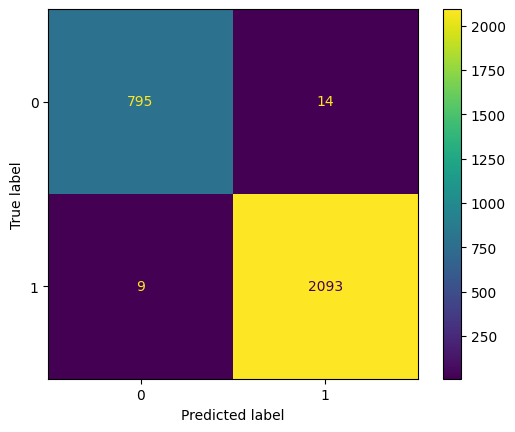

In [9]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [10]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test loss: {test_loss:.6f}")
print(f"Test accuracy: {accuracy_score(y_true, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_true, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_true, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test loss: 0.000171
Test accuracy: 0.992099
Test balanced accuracy: 0.989207
Test f1 score: 0.994536
Test precision: 0.993355
Test recall: 0.995718


In [11]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       809
           1       0.99      1.00      0.99      2102

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911



## Visualizing Attention Map

In [12]:
X_train_neg = X_train[y_train == 0]
X_train_pos = X_train[y_train == 1]

y_train_neg = y_train[y_train == 0]
y_train_pos = y_train[y_train == 1]

neg_dataset = PTB_Dataset(X_train_neg, y_train_neg)
pos_dataset = PTB_Dataset(X_train_pos, y_train_pos)

In [13]:
x, label = neg_dataset[1]
print(x.shape)
_, weights = model(x.to(DEVICE).unsqueeze(0), get_weights=True)

torch.Size([187, 1])


In [14]:
weights[0].shape

torch.Size([1, 187, 187])

In [15]:
X_train_neg[0]

array([0.92382377, 0.7669903 , 0.29424945, 0.        , 0.13442868,
       0.2755788 , 0.41299477, 0.32113516, 0.30321136, 0.32860345,
       0.30918595, 0.32636297, 0.33009708, 0.33009708, 0.35026139,
       0.36743838, 0.3965646 , 0.39058998, 0.41000748, 0.44585511,
       0.45407021, 0.48842421, 0.523525  , 0.53846157, 0.60940999,
       0.592233  , 0.63405526, 0.62882751, 0.63554889, 0.65646005,
       0.66616881, 0.67737114, 0.6348021 , 0.59148616, 0.5660941 ,
       0.51530993, 0.49663928, 0.43988052, 0.41448843, 0.42793128,
       0.38909635, 0.41224796, 0.38984317, 0.38760269, 0.42120987,
       0.39581779, 0.42120987, 0.41150111, 0.39880508, 0.40403286,
       0.40179238, 0.40702015, 0.39058998, 0.39357731, 0.45780432,
       0.48543689, 0.52203137, 0.55489171, 0.55414486, 0.57505602,
       0.58103061, 0.57281554, 0.62509334, 0.5496639 , 0.50933534,
       0.45780432, 0.41822255, 0.38237491, 0.34727409, 0.35772964,
       0.3278566 , 0.33233756, 0.32561612, 0.34129947, 0.39432

### Attention Map: Aggregating over All Layers

torch.Size([1, 187, 187])


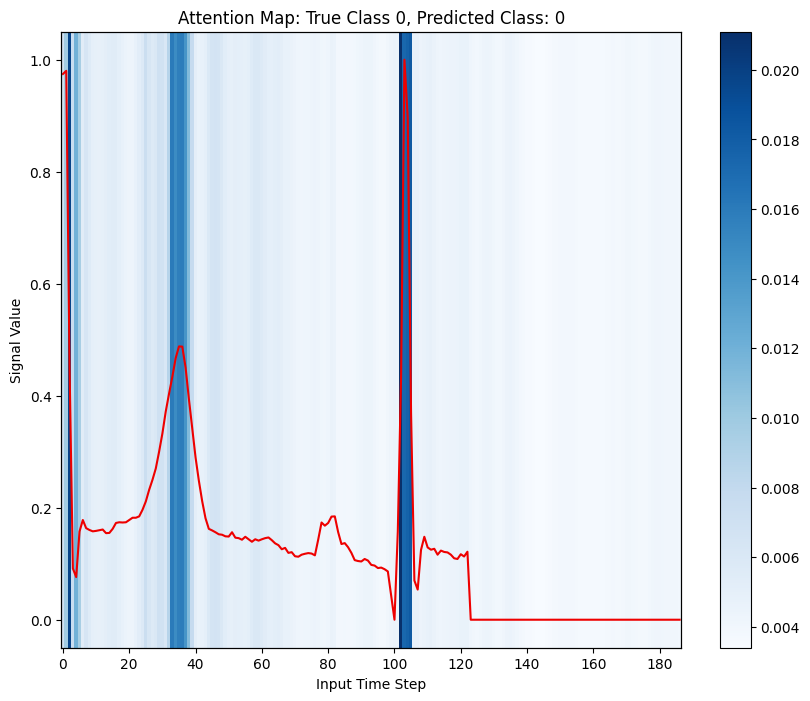

In [16]:
def plot_agg_attention_map(
    model: nn.Module,
    dataset: Dataset,
    idx: int,
    fig: plt.figure,
    ax1: plt.axes,
) -> None:
    x, label = dataset[idx]
    model.eval()
    logit, weights = model(x.to(DEVICE).unsqueeze(0), get_weights=True)
    pred = torch.argmax(logit, dim=1).item()
    true = label.item()
    
    print(weights[0].shape)

    # stack the weights of all attention layers
    stacked_weights = torch.stack(weights).squeeze(
        1
    )  # shape: (num_layers, query_len, key_len)]
    # aggregate over layers
    agg_weights = stacked_weights.mean(dim=0)  # shape: (, query_len, key_len)
    # aggregate over output sequence
    mean_weights = (
        agg_weights.mean(axis=0).squeeze(0).cpu().detach().numpy()
    )  # shape: (key_len,)

    # by adding a new dummy axis, we can use matshow to plot the 2D attention matrix for a 1D time series
    cax = ax1.imshow(mean_weights[None, :], aspect="auto", cmap="Blues")
    fig.colorbar(cax, ax=ax1)
    ax1.set_yticks([])  # hide y-axis ticks for the heatmap
    ax1.set_xticks([])  # hide x-axis ticks for the heatmap

    # plot time series in black above
    ax2 = ax1.twinx()
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")
    ax2.plot(range(x.shape[0]), x, color="#EE0000FF")  # ggsci aaas red color for line
    ax1.set_xlabel("Input Time Step")
    ax2.set_ylabel("Signal Value")
    ax2.set_title(
        f"Attention Map: True Class {[0, 1][true]}, Predicted Class: {[0, 1][pred]}"
    )
    
    # adding x ticks:
    ticks = range(0, 188, 20)  # 0 to 187 by 20
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(ticks)


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_agg_attention_map(model, neg_dataset, 2, fig, ax)

torch.Size([1, 187, 187])
torch.Size([1, 187, 187])
torch.Size([1, 187, 187])
torch.Size([1, 187, 187])
torch.Size([1, 187, 187])
torch.Size([1, 187, 187])
torch.Size([1, 187, 187])
torch.Size([1, 187, 187])


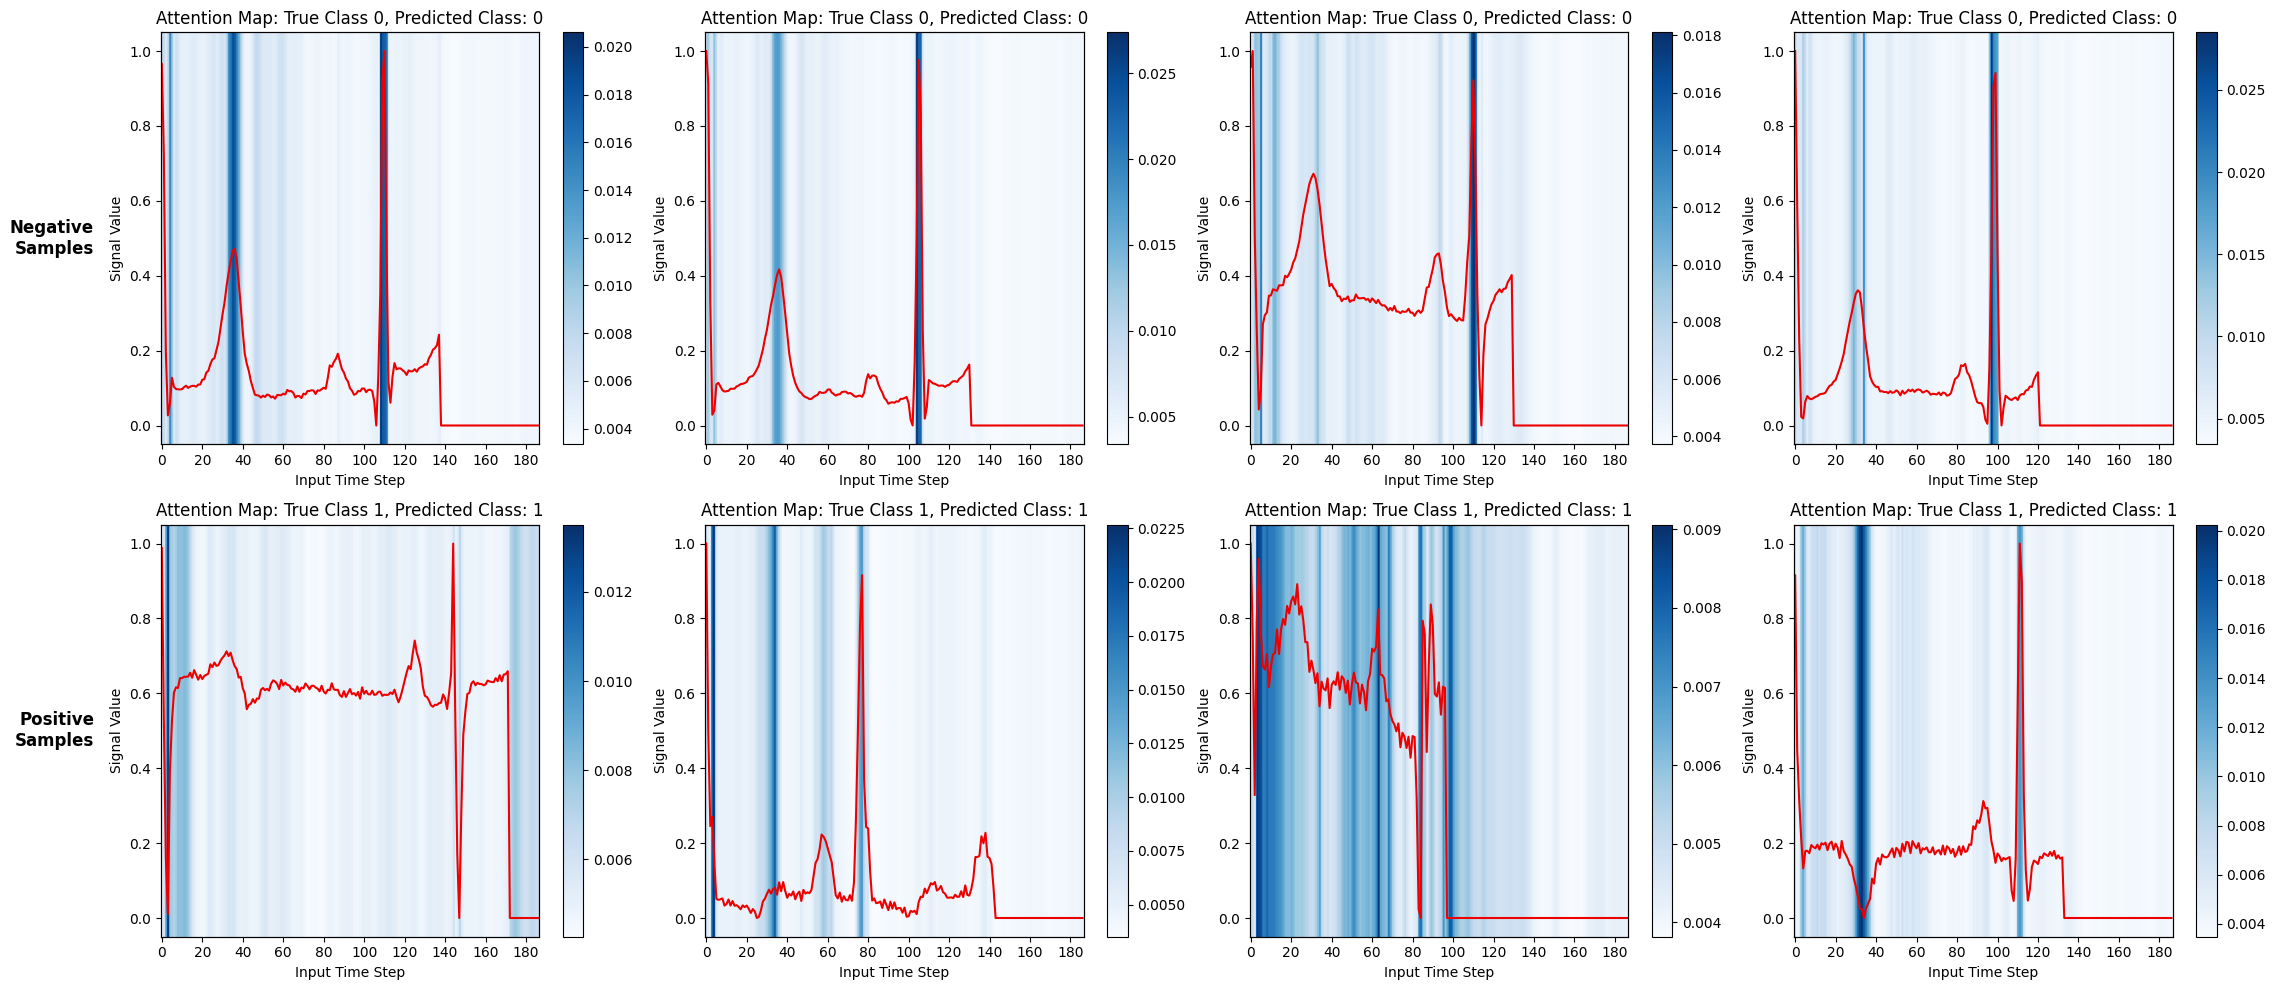

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(25, 10))  

random_neg_idx = np.random.choice(len(neg_dataset), 4, replace=False)
random_pos_idx = np.random.choice(len(pos_dataset), 4, replace=False)

for i in range(4):
    row = 0
    col = i % 4
    
    ax1 = axs[row, col]
    plot_agg_attention_map(model, neg_dataset, random_neg_idx[i], fig, ax1)
    
for j in range(4):
    row = 1
    col = j % 4
    
    ax1 = axs[row, col]
    plot_agg_attention_map(model, pos_dataset, random_pos_idx[j], fig, ax1)

pad = 40
rows = ["Negative\nSamples", "Positive\nSamples"]
# copied from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', fontweight = 'bold')

plt.tight_layout()  
plt.subplots_adjust(left = 0.15)


### Attention Map: Plotting for Each Layer

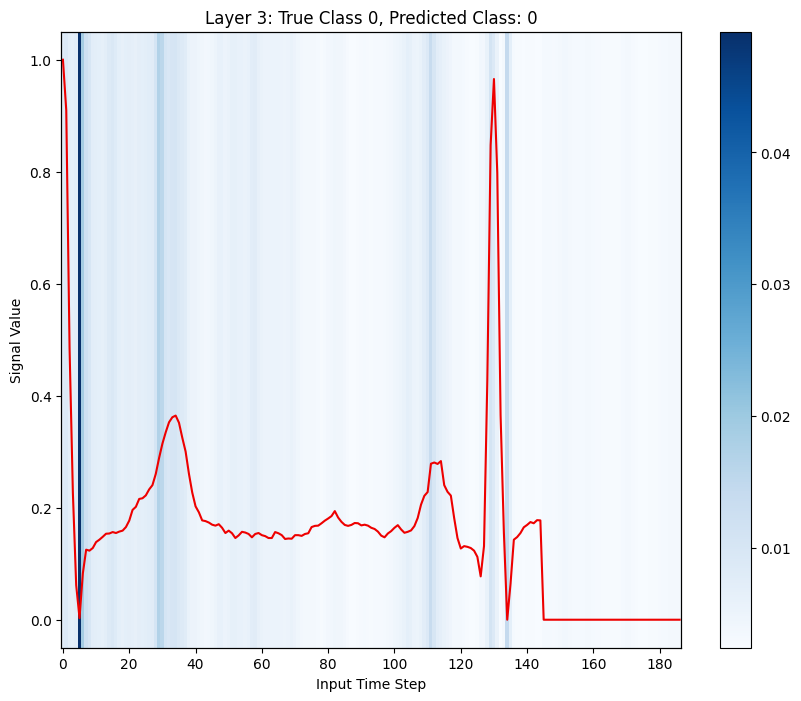

In [18]:
# same as above but plot every layer separately:
def plot_layers_attention_map(
    model: nn.Module,
    dataset: Dataset,
    idx: int,
    layer_num: int,
    fig: plt.figure,
    ax1: plt.axes,
) -> None:
    x, label = dataset[idx]
    model.eval()
    logit, weights = model(x.to(DEVICE).unsqueeze(0), get_weights=True)
    pred = torch.argmax(logit, dim=1).item()
    true = label.item()

    # stack the weights of all attention layers
    stacked_weights = torch.stack(weights).squeeze(
        1
    )  # shape: (num_layers, query_len, key_len)]
    layer_weights = stacked_weights[layer_num]  # shape: (query_len, key_len)
    # aggregate over output sequence
    mean_weights = (
        layer_weights.mean(axis=0).squeeze(0).cpu().detach().numpy()
    )  # shape: (key_len,)


    # by adding a new dummy axis, we can use matshow to plot the 2D attention matrix for a 1D time series
    cax = ax1.imshow(mean_weights[None, :], aspect="auto", cmap="Blues")
    fig.colorbar(cax, ax=ax1)
    ax1.set_yticks([])  # hide y-axis ticks for the heatmap
    ax1.set_xticks([])  # hide x-axis ticks for the heatmap

    # plot time series in black above
    ax2 = ax1.twinx()
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")
    ax2.plot(range(x.shape[0]), x, color="#EE0000FF")  # ggsci aaas red color for line
    ax1.set_xlabel("Input Time Step")
    ax2.set_ylabel("Signal Value")
    ax2.set_title(
        f"Layer {layer_num + 1}: True Class {[0, 1][true]}, Predicted Class: {[0, 1][pred]}"
    )
    
    # adding x ticks:
    ticks = range(0, 188, 20)  # 0 to 187 by 20
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(ticks)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_layers_attention_map(
    model=model, 
    dataset=neg_dataset, 
    idx=1, 
    layer_num=2, 
    fig=fig, 
    ax1=ax
)

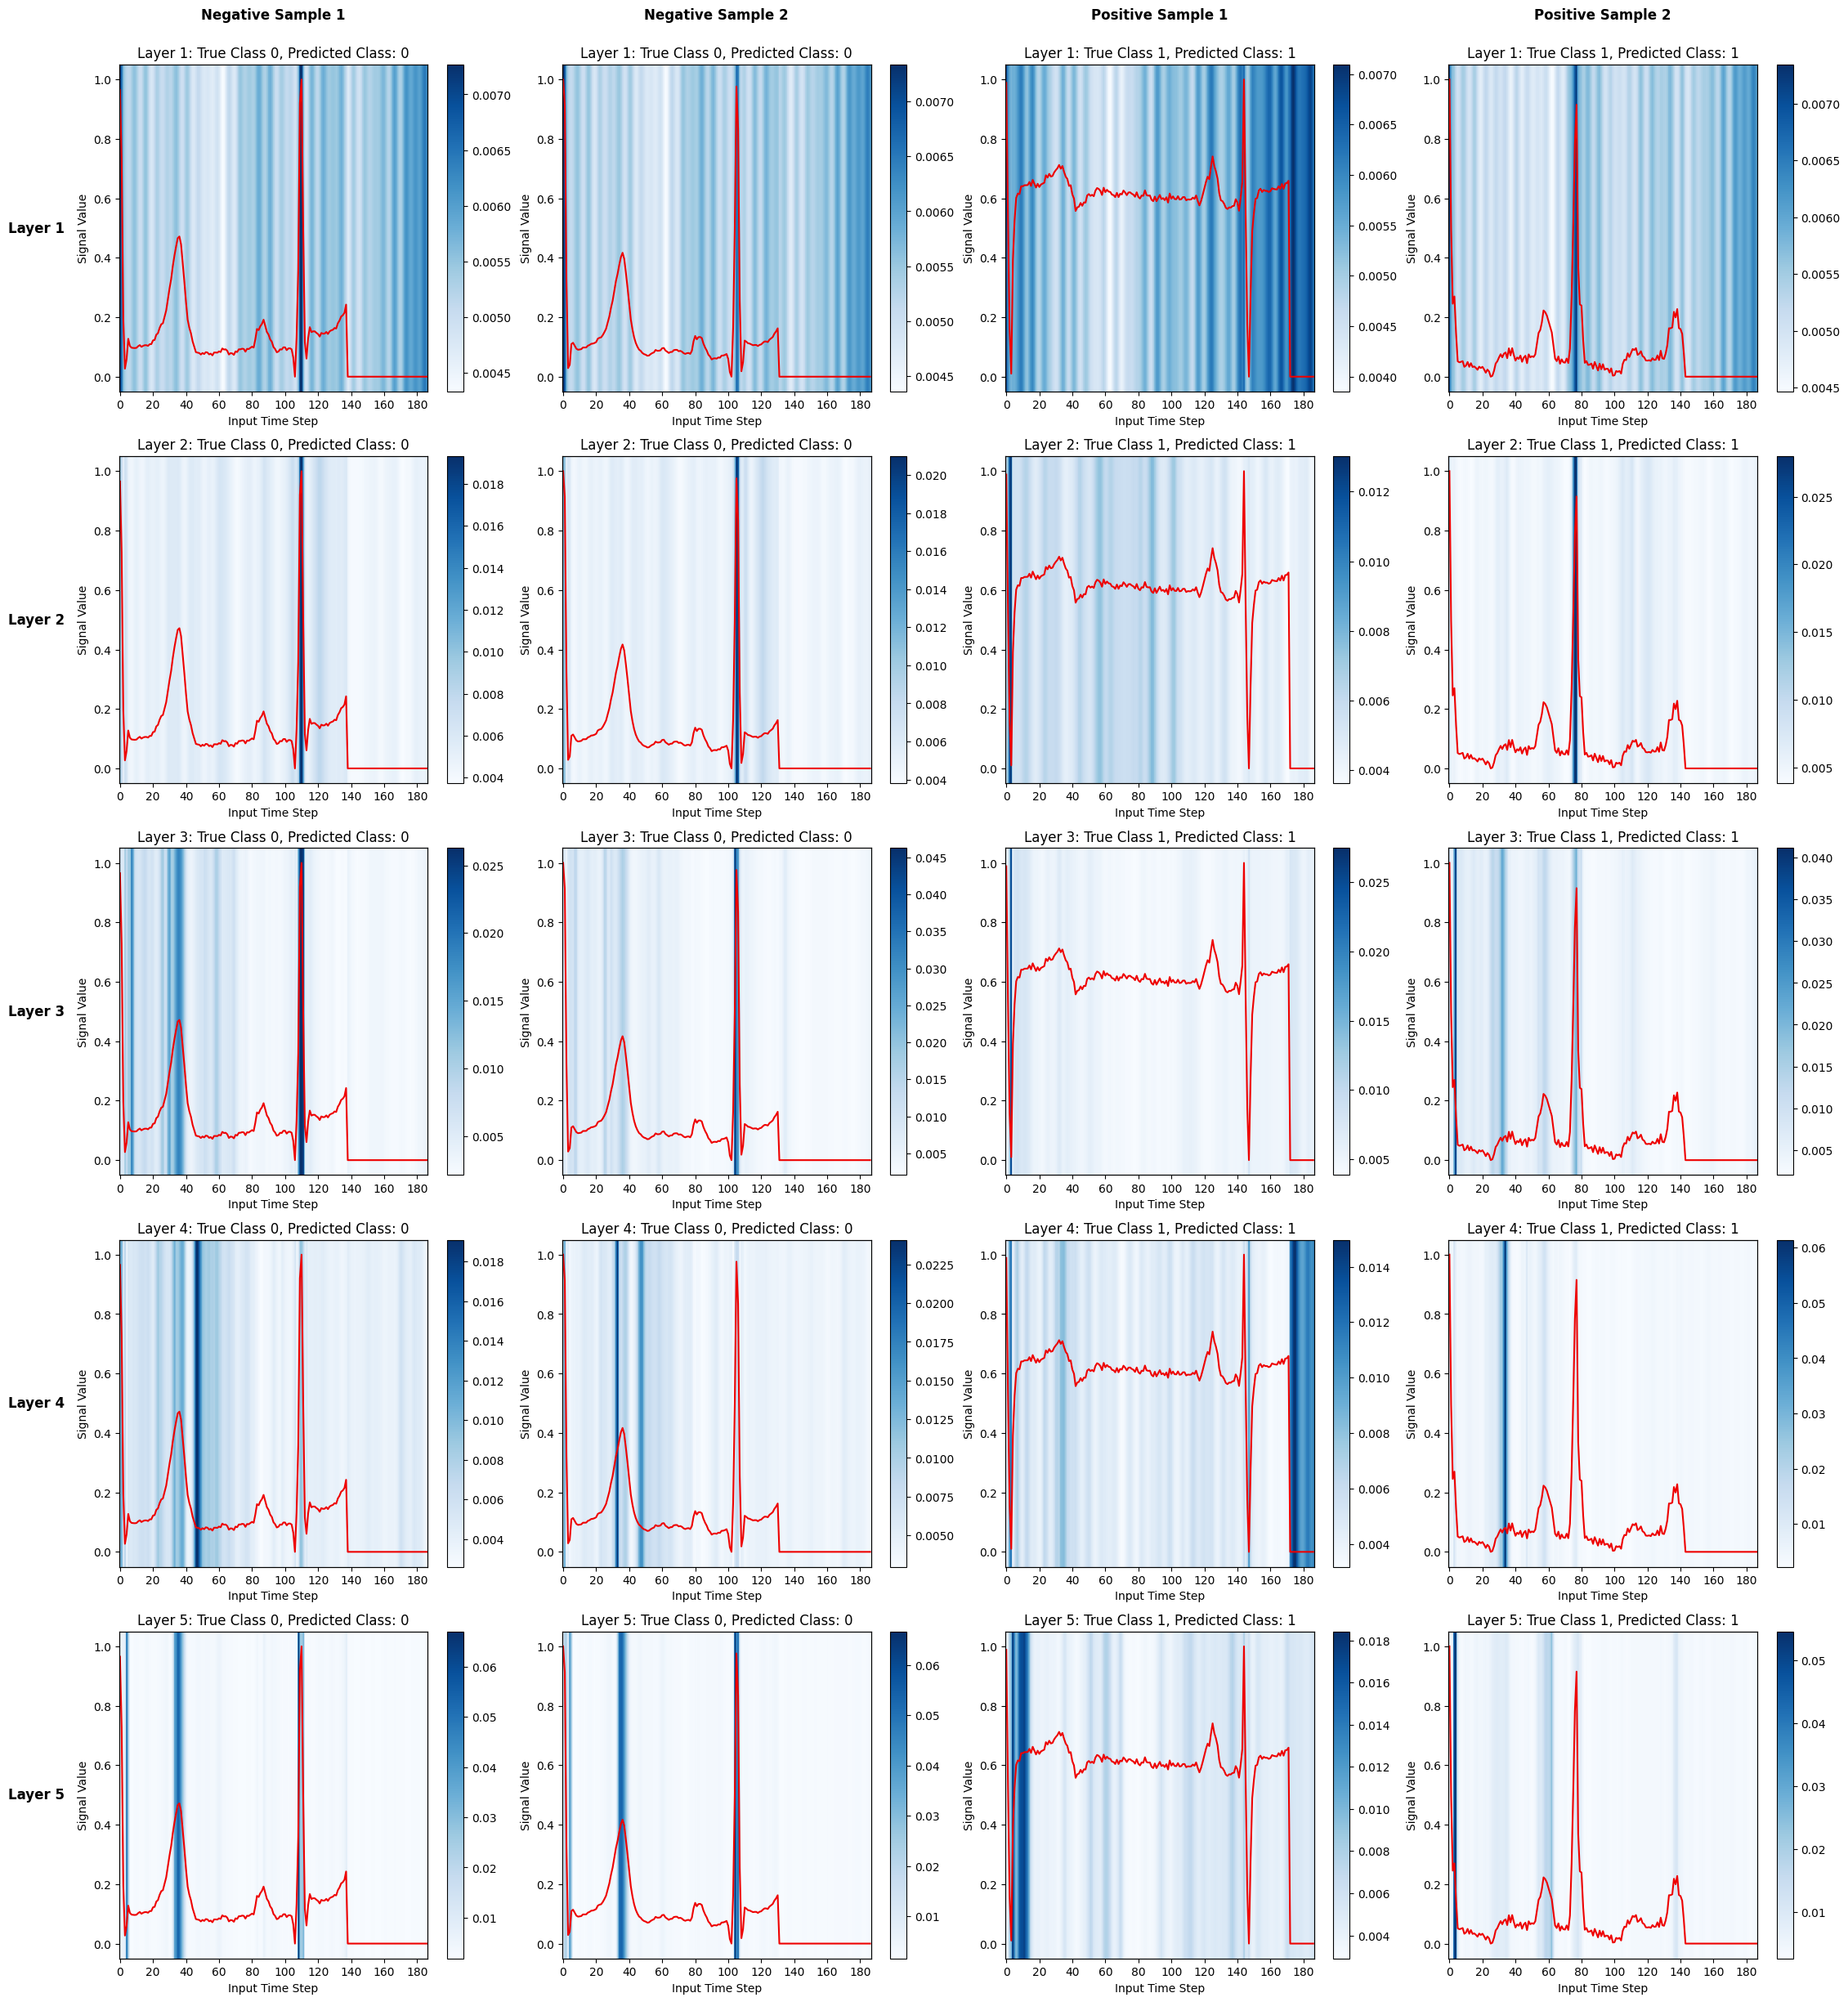

In [19]:
np.random.seed(config["general"]["seed"])
fig, axs = plt.subplots(5, 4, figsize=(25, 25))  

random_neg_idx = np.random.choice(len(neg_dataset), 2, replace=False)
random_pos_idx = np.random.choice(len(pos_dataset), 2, replace=False)

for i, idx in enumerate(random_neg_idx):
    for k in range(5):
        row = k
        col = i
        
        ax1 = axs[row, col]
        plot_layers_attention_map(
            model=model, 
            dataset=neg_dataset, 
            idx=idx, 
            layer_num=k, 
            fig=fig, 
            ax1=ax1
        )
    
for j, idx in enumerate(random_pos_idx):
    for k in range(5):
        row = k
        col = j + 2
    
        ax1 = axs[row, col]
        plot_layers_attention_map(
            model=model, 
            dataset=pos_dataset, 
            idx=idx, 
            layer_num=k, 
            fig=fig, 
            ax1=ax1
        )
        
rows = ["Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5"]
cols = ["Negative Sample 1", "Negative Sample 2", "Positive Sample 1", "Positive Sample 2"]


# copied from: https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 40
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight = 'bold')

# copied from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', fontweight = 'bold')

fig.tight_layout()  
fig.subplots_adjust(left=0.15, top=0.95)